In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions.import_dmr import *
import textwrap
import pickle
import difflib

In [2]:
save = True
load = False

In [3]:
esmr_data = read_esmr(save=save, load=load)
unique_parameter_codes = pd.read_csv('processed_data/dmr_esmr_ir_mapping.csv')['PARAMETER_CODE'].unique()

ESMR data has 23402599 ESMR events and 458 unique facilities
ESMR data has 0 ESMR events and 0 unique facilities that match facilities list
ESMR data has 0 ESMR events and 0 unique facilities that match facilities list and are not NA
ESMR data has 0 ESMR events and 0 unique facilities that match facilities list and are not NA and are in the analysis date range


In [4]:
slope_threshold = 0.05
limit_threshold = 0.1
fraction_threshold = 0.5

def create_facility_dict(data_dict):
    """
    Create a subset of the data_dict for each facility (from NPDES/DMR list)for each year in the analysis range.
    For each facility, calculate the percentage of reports for each parameter which are within the buffer % of the limit.
    """
    facility_dict = {}
    current_year = 2023

    # Pre-filter the data for selected pollutants
    filtered_data = {year: data_dict[current_year][data_dict[year]['PARAMETER_CODE'].isin(unique_parameter_codes)] for year in analysis_range}

    count = 0
    for NPDES_code in data_dict[current_year]['EXTERNAL_PERMIT_NMBR'].unique():
        count += 1
        if count % 50 == 0:
            print(f'{count} facilities processed')
        facility_dict[NPDES_code] = {}
        for parameter_code in unique_parameter_codes:
            master_pollutant_data = []
            percent_near_exceedance = {}
            
            for year in analysis_range:
                year_pollutant_data = filtered_data[year][(filtered_data[year]['EXTERNAL_PERMIT_NMBR'] == NPDES_code) & (filtered_data[year]['PARAMETER_CODE'] == parameter_code)]
                master_pollutant_data.append(year_pollutant_data)
                if len(year_pollutant_data) > 0:
                    percent_of_limit = year_pollutant_data['DMR_VALUE_STANDARD_UNITS'] / year_pollutant_data['LIMIT_VALUE_STANDARD_UNITS']
                    qualifier = year_pollutant_data['LIMIT_VALUE_QUALIFIER_CODE'].iloc[0]
                    if qualifier in ['<=', '<']:
                        percent_near_exceedance[year] = len(percent_of_limit[percent_of_limit > (1 - limit_threshold)]) / len(percent_of_limit)
                    elif qualifier in ['>=', '>']:
                        percent_near_exceedance[year] = len(percent_of_limit[percent_of_limit < (1 + limit_threshold)]) / len(percent_of_limit)
                else:
                    percent_near_exceedance[year] = 0
            
            master_pollutant_data_df = pd.concat(master_pollutant_data, ignore_index=True)
            date = pd.to_numeric(master_pollutant_data_df['MONITORING_PERIOD_END_DATE_NUMERIC'], errors='coerce')
            datetimes = master_pollutant_data_df['MONITORING_PERIOD_END_DATE']
            values = pd.to_numeric(master_pollutant_data_df['DMR_VALUE_STANDARD_UNITS'], errors='coerce')
            
            if datetimes.max().year <= 2022:
                date = []
                datetimes = []
                values = []

            if len(date) > 1:
                slope, intercept = np.polyfit(date, values, 1)
            else:
                slope = 0
                intercept = 0
            
            facility_dict[NPDES_code][parameter_code] = {
                'percent_near_exceedance': percent_near_exceedance,
                'slope': slope,
                'intercept': intercept,
                'data': master_pollutant_data_df,
                'slope_dates': date,
                'slope_datetimes': master_pollutant_data_df['MONITORING_PERIOD_END_DATE'],
                'slope_values': values,
                'slope_intercept': intercept,
                'limits': pd.to_numeric(master_pollutant_data_df['LIMIT_VALUE_STANDARD_UNITS'], errors='coerce'),
                'qualifiers': master_pollutant_data_df['LIMIT_VALUE_QUALIFIER_CODE'].values
            }
        
    return facility_dict

In [5]:
if save:  # save facility_dict and data_dict to file
    data_dict = read_all_dmrs(save=save, load=load)
    facility_dict = create_facility_dict(data_dict)
    with open('processed_data/facility_dict.pkl', 'wb') as f:
        pickle.dump(facility_dict, f)
    with open('processed_data/data_dict.pkl', 'wb') as f:
        pickle.dump(data_dict, f)
if load:
    facility_dict = pickle.load(open('processed_data/facility_dict.pkl', 'rb'))
    # data_dict = pickle.load(open('processed_data/data_dict.pkl', 'rb'))
    data_dict = read_all_dmrs(save=save, load=load)

2014 DMR data has 375069 DMR events and 269 unique permits
2014 DMR data has 43691 DMR events and 142 unique permits after filtering
2015 DMR data has 370700 DMR events and 264 unique permits
2015 DMR data has 43285 DMR events and 140 unique permits after filtering
2016 DMR data has 383259 DMR events and 268 unique permits
2016 DMR data has 44070 DMR events and 144 unique permits after filtering
2017 DMR data has 524186 DMR events and 454 unique permits
2017 DMR data has 53140 DMR events and 190 unique permits after filtering
2018 DMR data has 540493 DMR events and 453 unique permits
2018 DMR data has 50577 DMR events and 186 unique permits after filtering
2019 DMR data has 527656 DMR events and 443 unique permits
2019 DMR data has 51803 DMR events and 194 unique permits after filtering
2020 DMR data has 537436 DMR events and 442 unique permits
2020 DMR data has 53075 DMR events and 196 unique permits after filtering
2021 DMR data has 532621 DMR events and 433 unique permits
2021 DMR d

/var/folders/qq/0h1nl0vj595_tgrwtkm73yjm0000gn/T/ipykernel_31574/403546003.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = {year: data_dict[current_year][data_dict[year]['PARAMETER_CODE'].isin(unique_parameter_codes)] for year in analysis_range}


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
facilities_with_slope, facilities_with_near_exceedance = [], []
for NPDES_code in data_dict[2023]['EXTERNAL_PERMIT_NMBR'].unique():
    for parameter_code in unique_parameter_codes:
        for year in analysis_range:
            # print(facility_dict[NPDES_code].keys())
            slope = facility_dict[NPDES_code][str(parameter_code)]['slope']
            intercept = facility_dict[NPDES_code][str(parameter_code)]['intercept']
            percent_near_exceedance = facility_dict[NPDES_code][str(parameter_code)]['percent_near_exceedance']
            master_pollutant_data_df = facility_dict[NPDES_code][str(parameter_code)]['data']
            date = facility_dict[NPDES_code][str(parameter_code)]['slope_dates']
            values = facility_dict[NPDES_code][str(parameter_code)]['slope_values']
            limits = facility_dict[NPDES_code][str(parameter_code)]['limits']
            qualifiers = facility_dict[NPDES_code][str(parameter_code)]['qualifiers']
    
        # Check for facilities with significant slope based on qualifier
        if len(qualifiers) > 0:
            if qualifiers[0] in ['<=', '<'] and slope > slope_threshold:
                facilities_with_slope.append((NPDES_code, parameter_code, limits[0]))
            elif qualifiers[0] in ['>=', '>'] and slope < -slope_threshold:
                facilities_with_slope.append((NPDES_code, parameter_code, limits[0]))
        
        # Check for facilities with near exceedance
        if any(percent_near_exceedance[year] > 0.5 for year in analysis_range):
            facilities_with_near_exceedance.append((NPDES_code, parameter_code, limits[0]))
facilities_with_slope_and_near_exceedance = list(set(facilities_with_slope) & set(facilities_with_near_exceedance))

In [ ]:
print(f'{len(facilities_with_slope)} facilities with slope > {slope_threshold*100}%')
print(f'{len(facilities_with_near_exceedance)} facilities with near exceedance > {limit_threshold*100}% more than')
print(f'{len(facilities_with_slope_and_near_exceedance)} facilities with both slope and near exceedance')
facilities_with_slope_and_near_exceedance_df = pd.DataFrame(facilities_with_slope_and_near_exceedance, columns=['NPDES_CODE', 'PARAMETER_CODE', 'LIMIT_VALUE_STANDARD_UNITS'])

679 facilities with slope > 5.0%
537 facilities with near exceedance > 10.0% more than
80 facilities with both slope and near exceedance


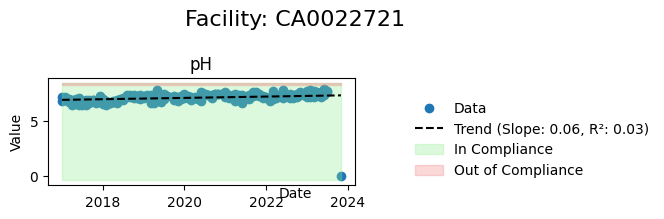

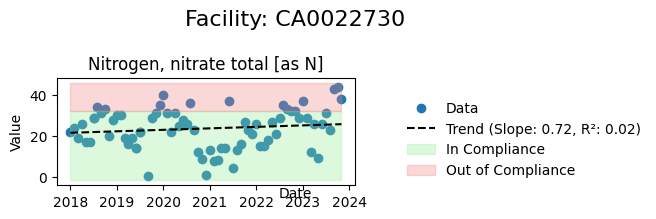

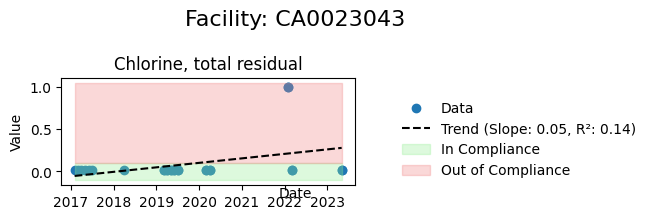

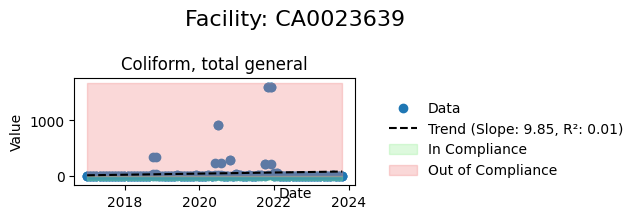

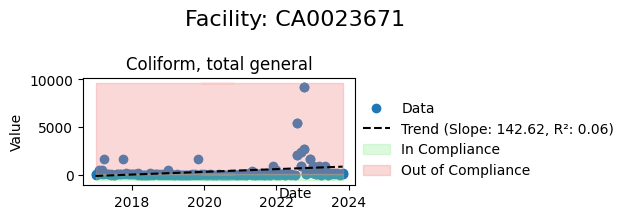

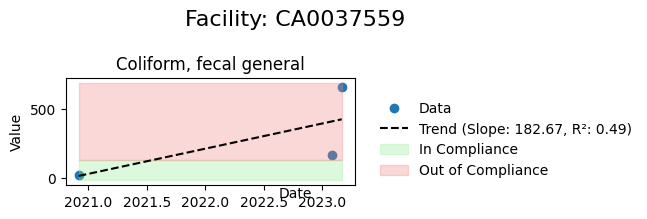

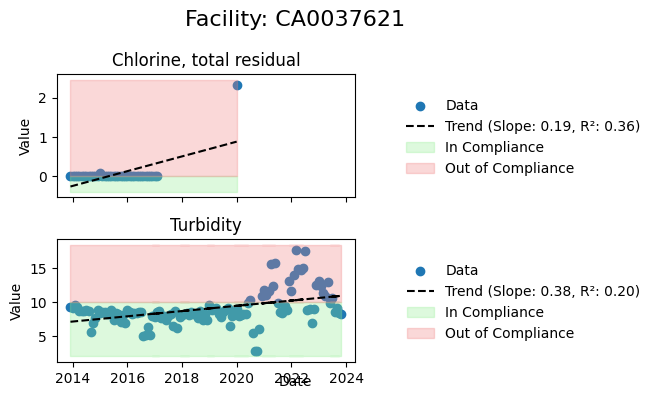

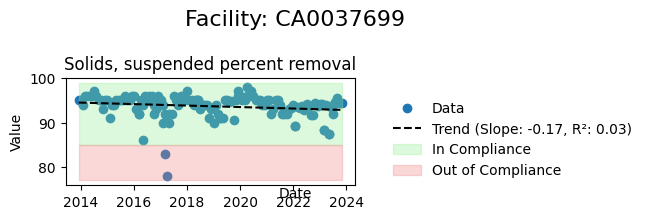

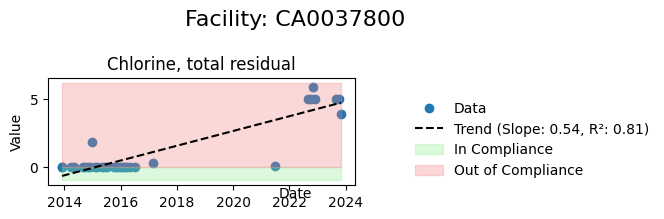

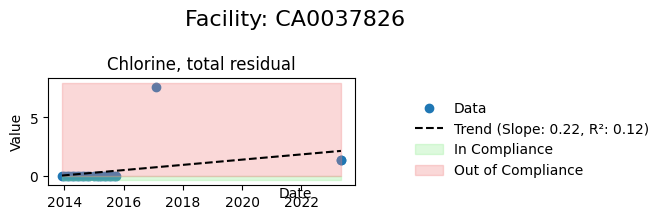

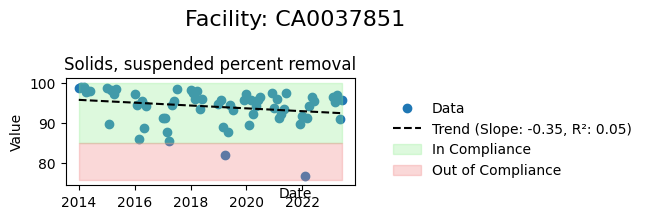

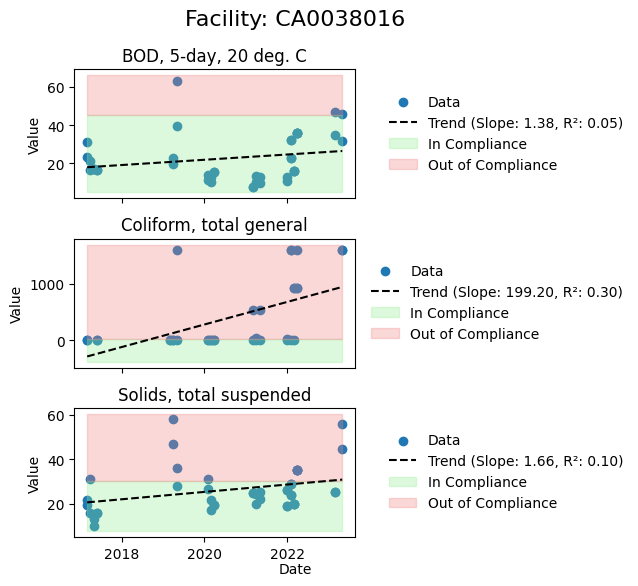

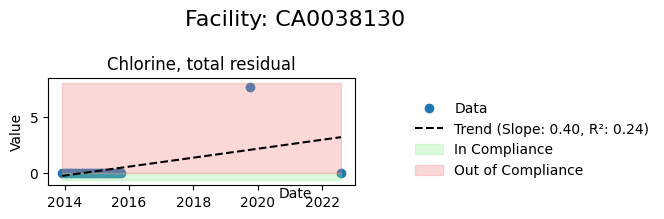

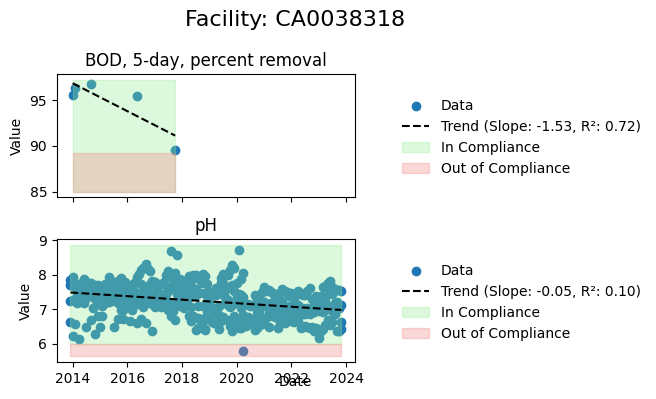

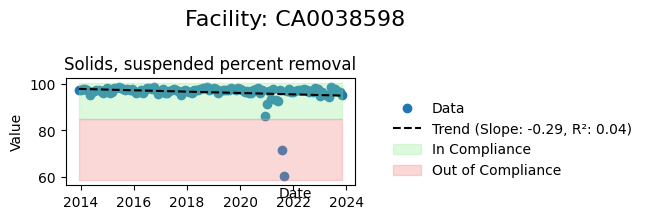

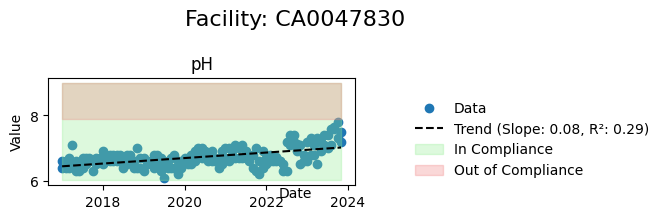

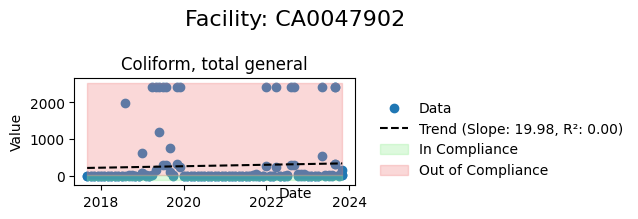

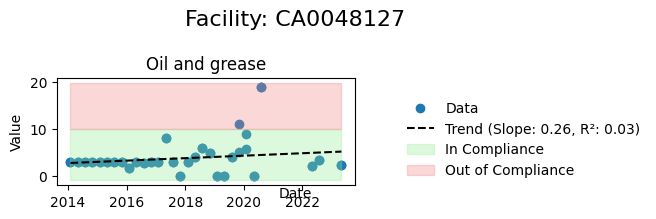

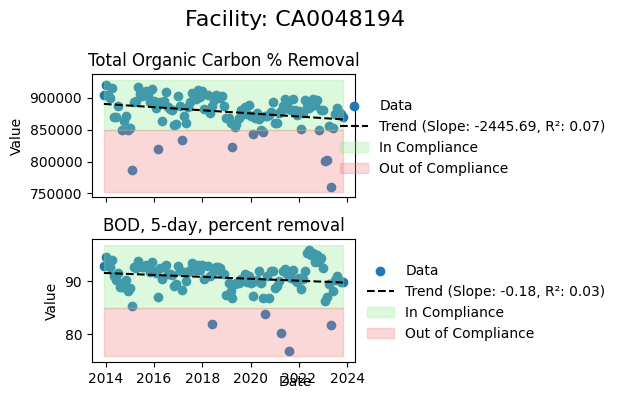

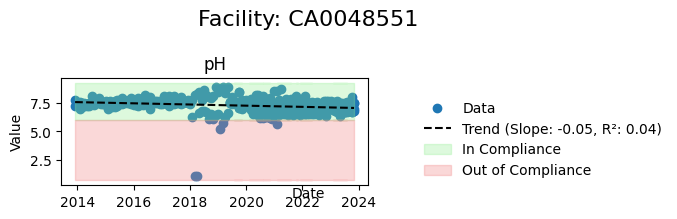

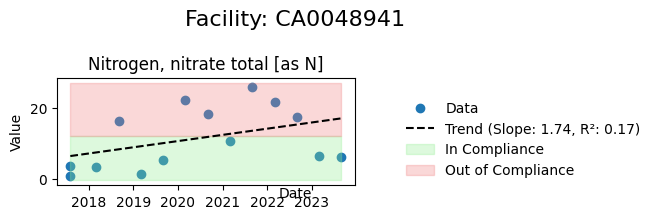

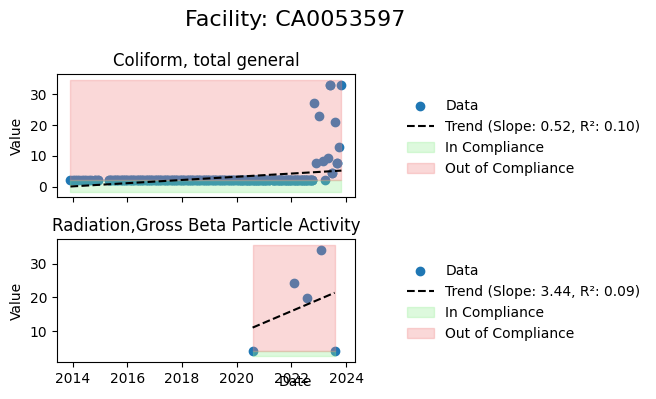

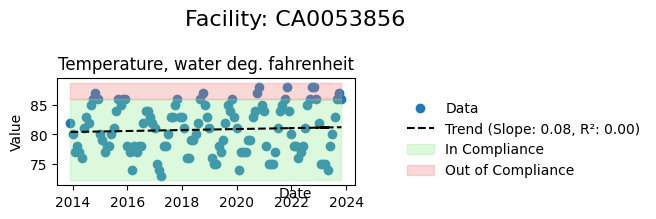

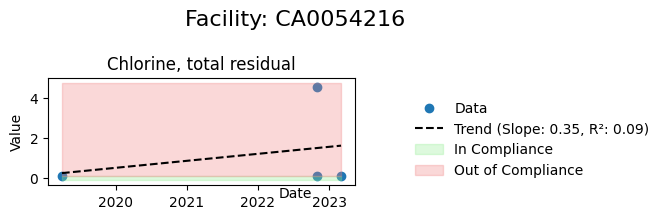

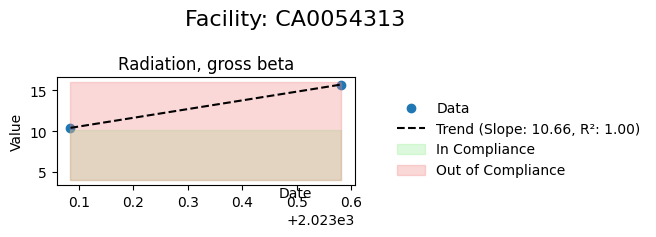

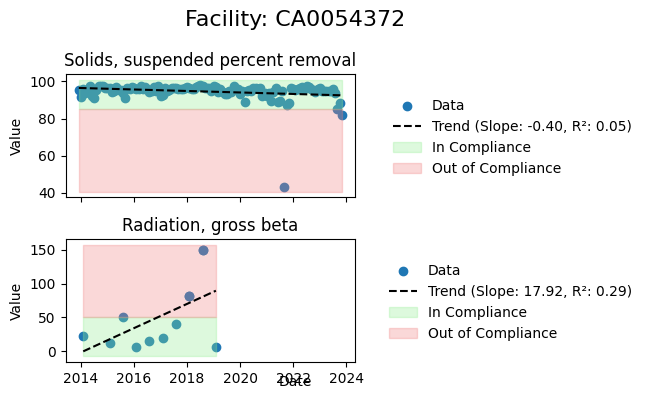

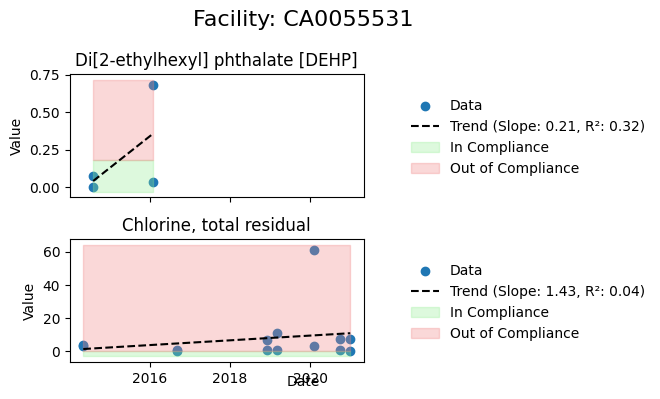

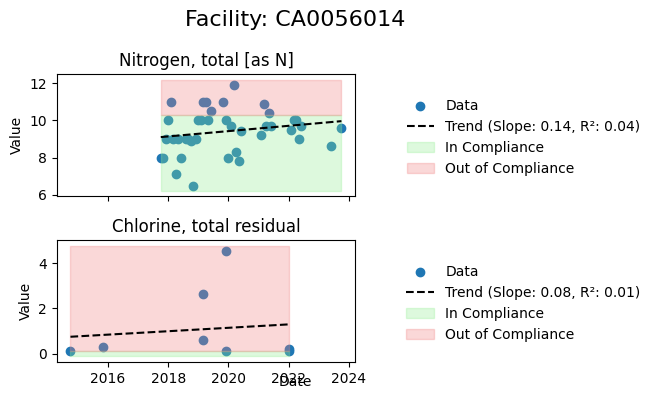

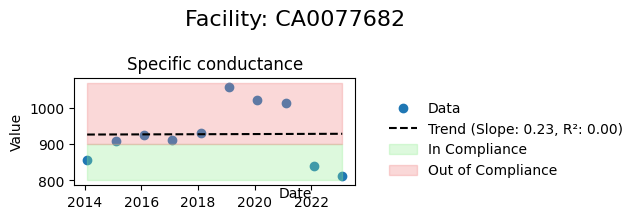

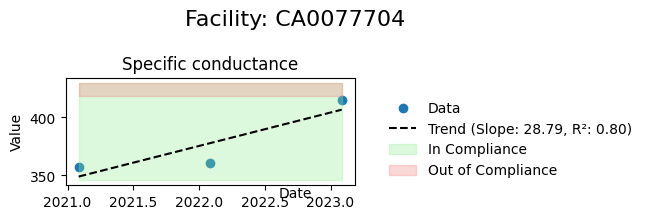

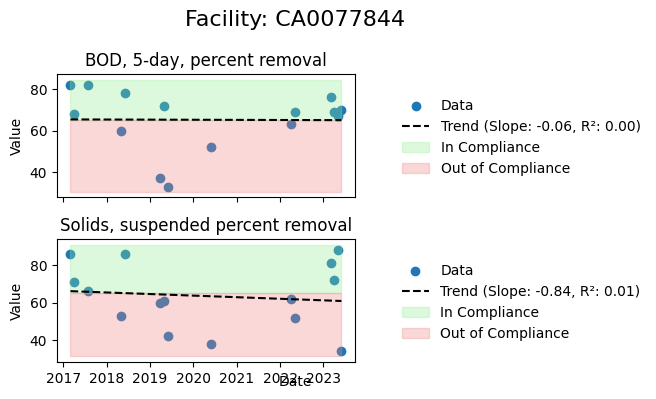

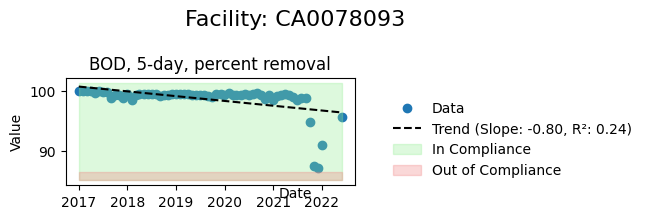

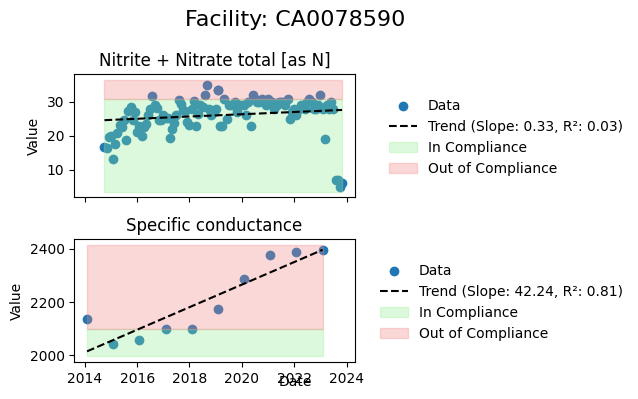

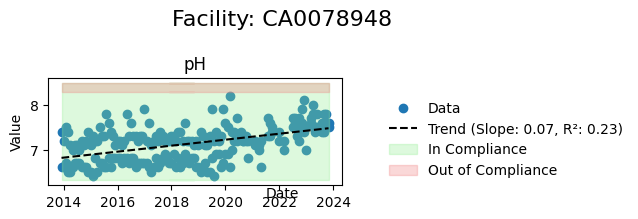

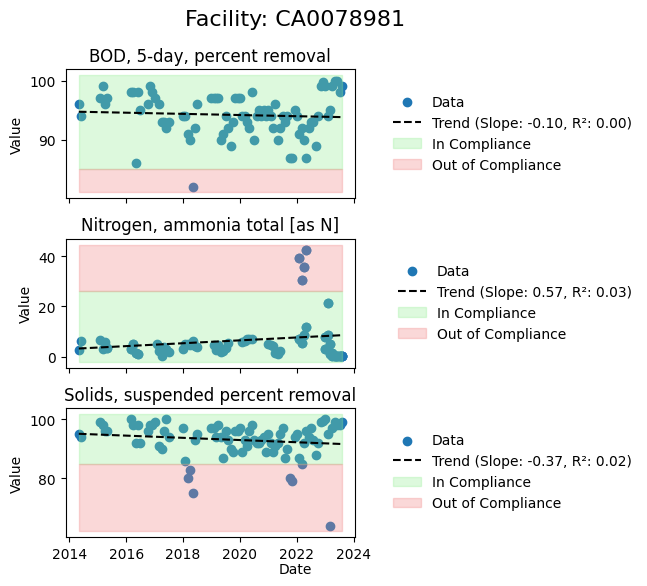

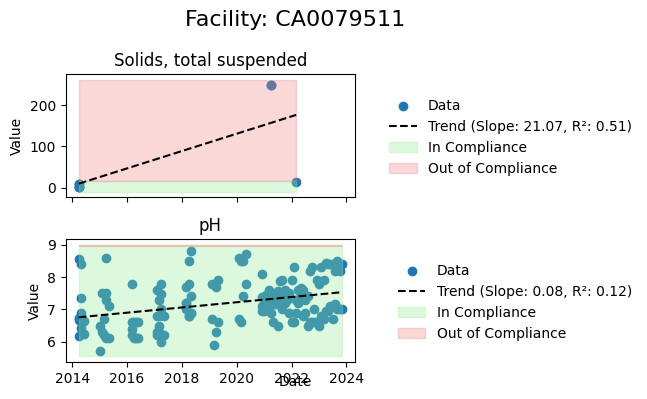

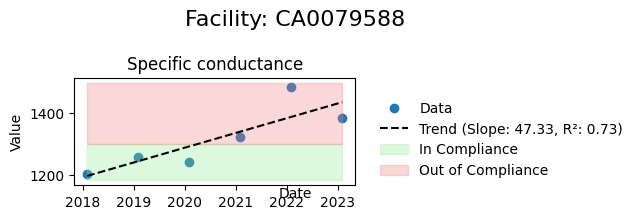

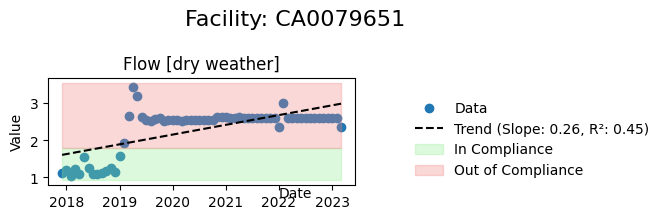

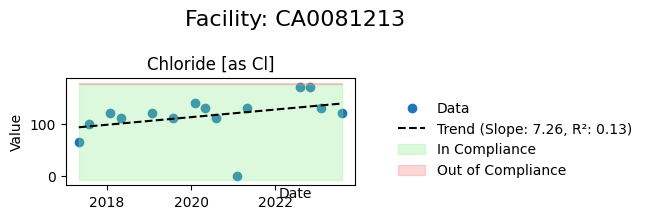

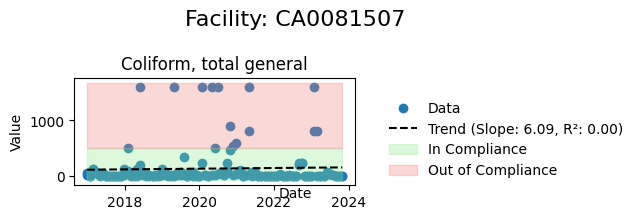

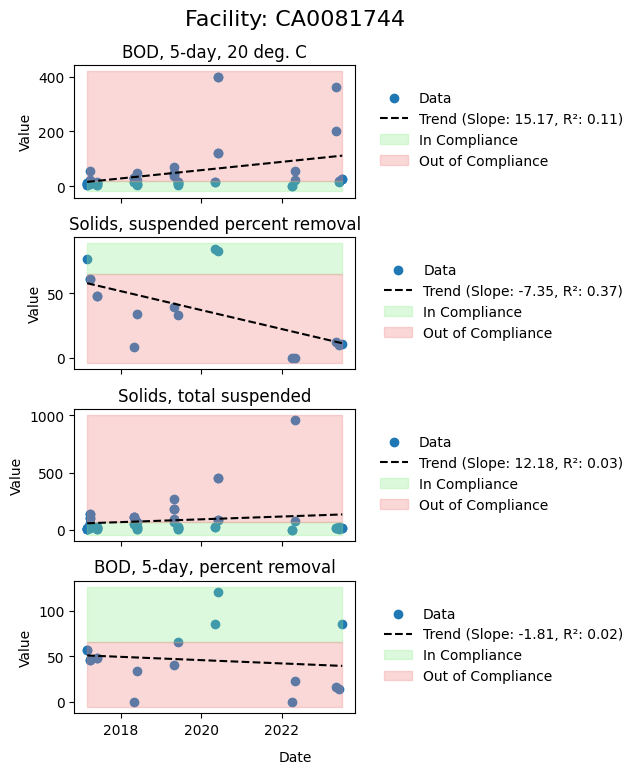

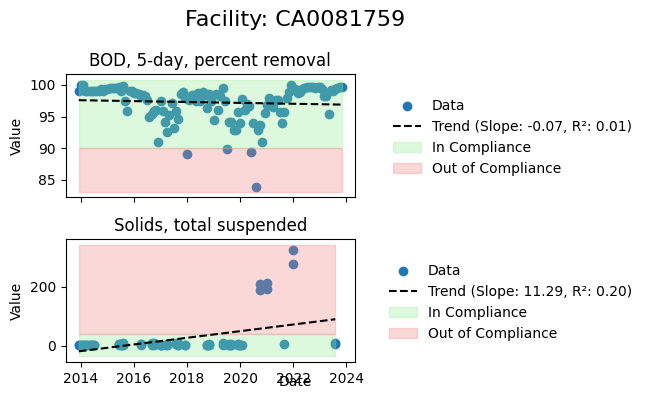

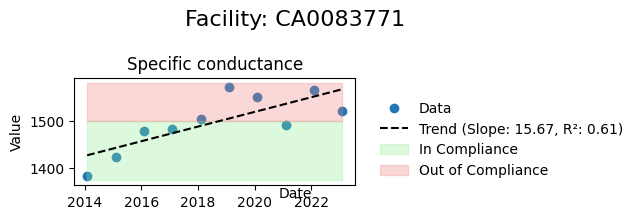

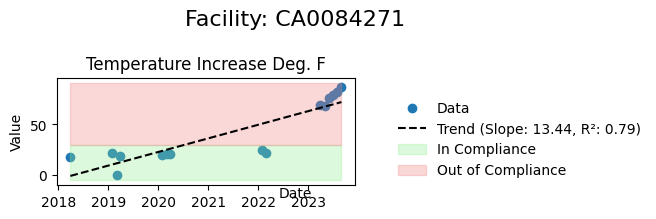

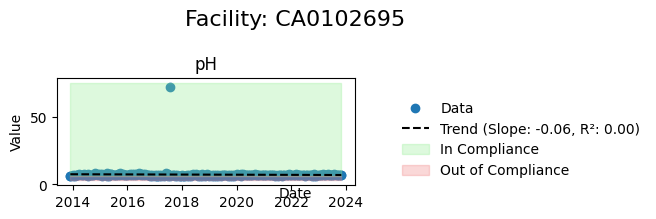

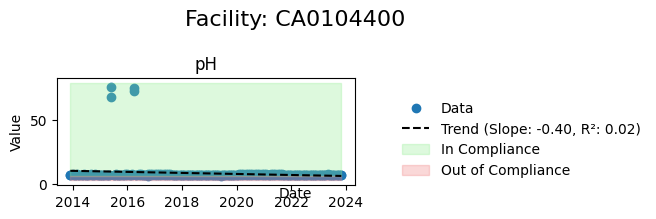

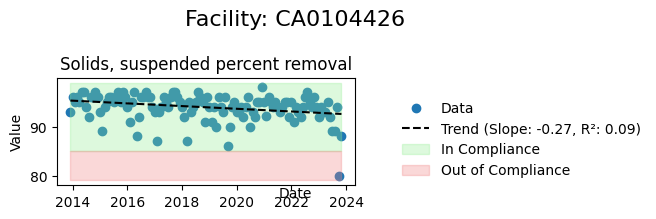

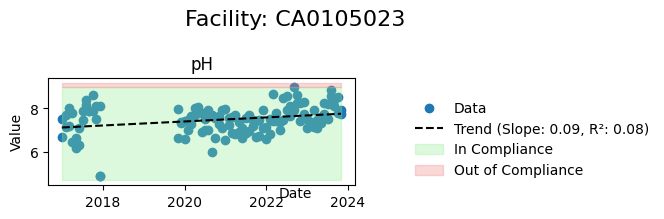

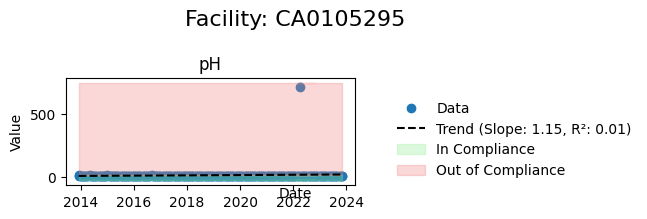

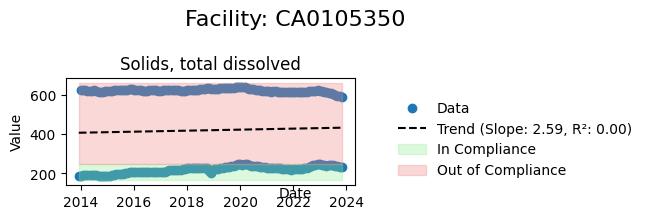

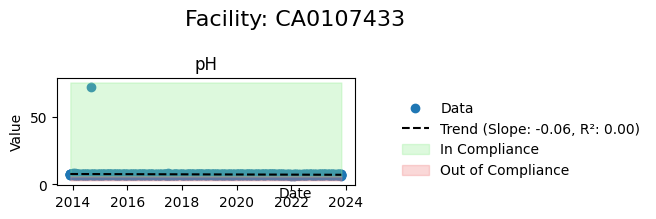

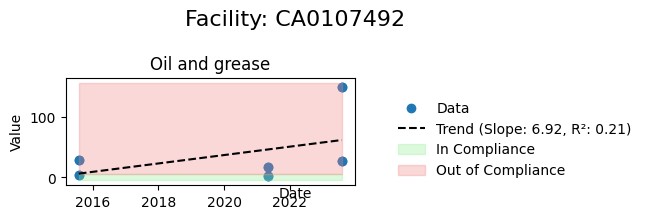

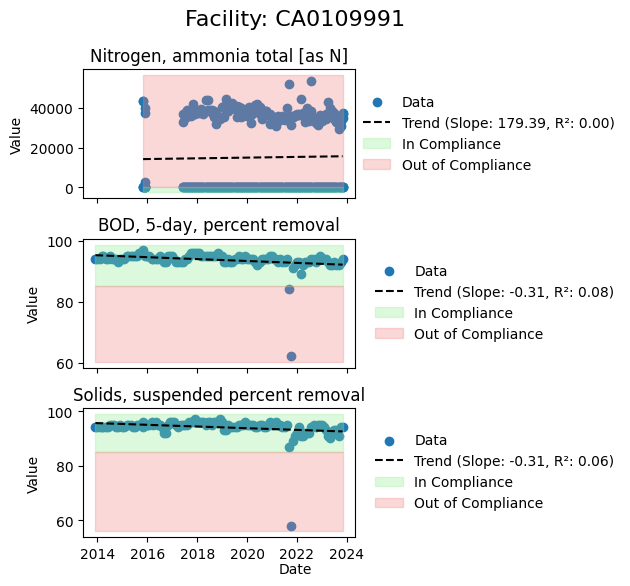

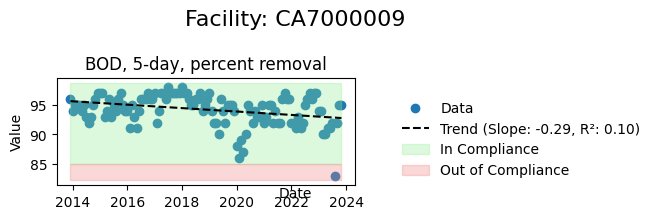

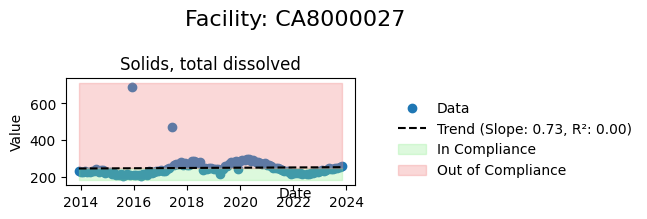

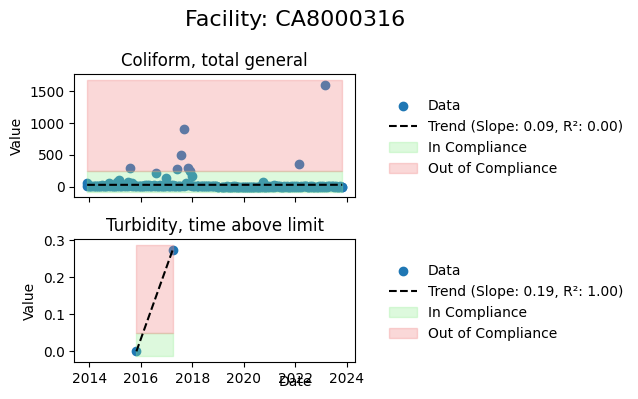

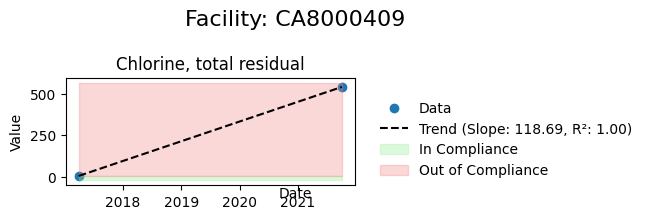

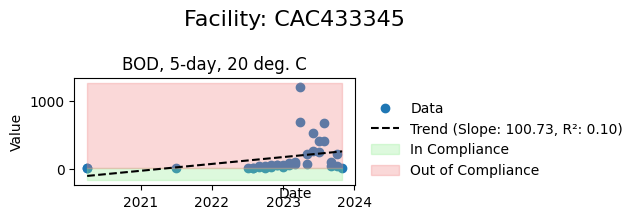

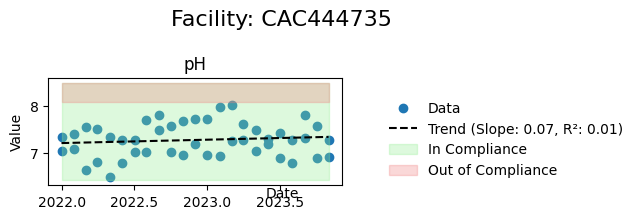

In [ ]:
# Group facilities with slope and near exceedance by NPDES_CODE
facilities_grouped = facilities_with_slope_and_near_exceedance_df.groupby('NPDES_CODE')

# Loop through each facility (NPDES_CODE) with at least one parameter with slope and near exceedance
for NPDES_CODE, group in facilities_grouped:
    num_parameters = len(group)
    fig, axs = plt.subplots(num_parameters, 1, figsize=(6, 2*num_parameters), sharex=True)
    fig.suptitle(f'Facility: {NPDES_CODE}', fontsize=16)
    
    for idx, (_, row) in enumerate(group.iterrows()):
        PARAMETER_CODE, LIMIT_VALUE = str(row['PARAMETER_CODE']), row['LIMIT_VALUE_STANDARD_UNITS']
        facility_data = facility_dict[NPDES_CODE][PARAMETER_CODE]
        parameter_desc = ref_parameter.loc[ref_parameter['PARAMETER_CODE'] == PARAMETER_CODE, 'PARAMETER_DESC'].values[0]
        qualifier = facility_data['qualifiers'][0]

        ax = axs[idx] if num_parameters > 1 else axs
        
        # plot data points
        ax.scatter(facility_data['slope_dates'], facility_data['slope_values'], label='Data')
        
        # plot trend line
        x = np.array(facility_data['slope_dates'])
        y = facility_data['intercept'] + facility_data['slope'] * x
        r2 = np.corrcoef(facility_data['slope_values'], y)[0, 1]**2
        ax.plot(x, y, 'k--', label=f'Trend (Slope: {facility_data["slope"]:.2f}, R²: {r2:.2f})')
        
        # shade areas above/below limit based on qualifier
        ylim = ax.get_ylim()
        if '>' in qualifier:
            ax.fill_between(x, LIMIT_VALUE, ylim[1], color='lightgreen', alpha=0.3, label='In Compliance')
            ax.fill_between(x, ylim[0], LIMIT_VALUE, color='lightcoral', alpha=0.3, label='Out of Compliance')
        elif '<' in qualifier:
            ax.fill_between(x, ylim[0], LIMIT_VALUE, color='lightgreen', alpha=0.3, label='In Compliance')
            ax.fill_between(x, LIMIT_VALUE, ylim[1], color='lightcoral', alpha=0.3, label='Out of Compliance')

        ax.set_ylabel('Value')
        ax.legend(loc='upper right', frameon=False, bbox_to_anchor=(2, 0.9))    
        ax.set_title(f'{parameter_desc}')

    fig.text(0.5, 0.04, 'Date', ha='center') # set common x-label

    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.91, 0.7), frameon=False)
    plt.tight_layout()
    plt.subplots_adjust(right=0.6, bottom=0.1)
    plt.savefig(f'processed_figures/slope_and_near_exceedence/{NPDES_CODE}.png')
    plt.show()

## Histograms of number of facilities frequently above limits

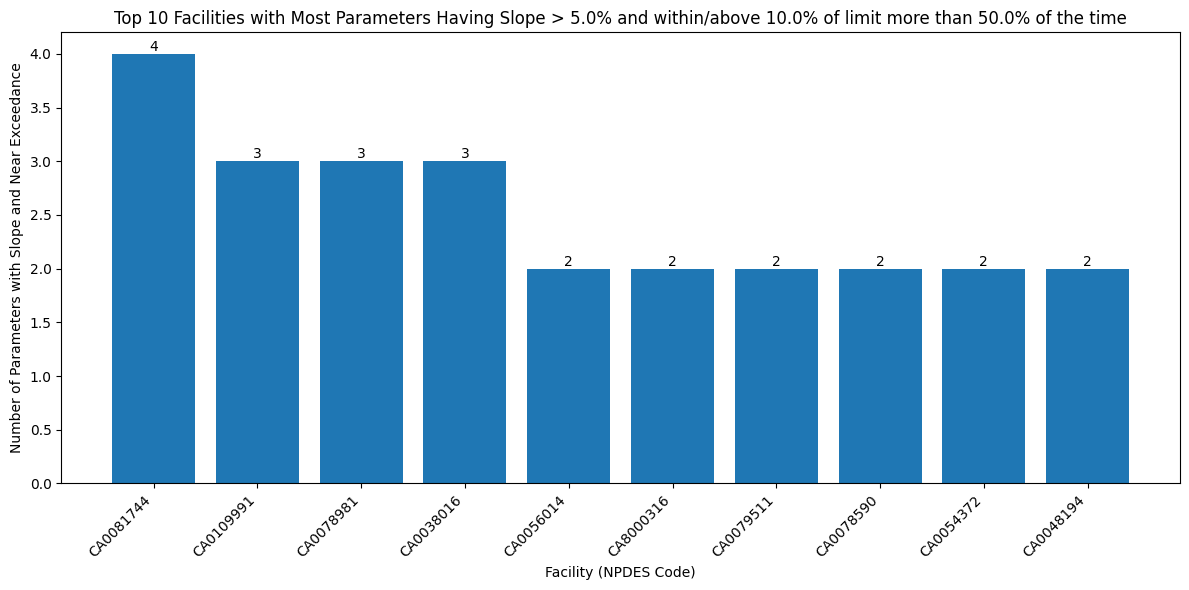

In [ ]:
buffer_values = [limit_threshold]

# Count the number of parameters for each facility with slope and near exceedance
num_parameters_per_facility = {}
for facility, parameter_code, _ in facilities_with_slope_and_near_exceedance:
    if facility not in num_parameters_per_facility:
        num_parameters_per_facility[facility] = set()
    num_parameters_per_facility[facility].add(parameter_code)

# Convert sets to counts
num_parameters_per_facility = {facility: len(parameters) for facility, parameters in num_parameters_per_facility.items()}

# Sort facilities by number of parameters and get top 10
top_10_facilities = dict(sorted(num_parameters_per_facility.items(), key=lambda x: x[1], reverse=True)[:10])

# Prepare data for plotting
facilities = list(top_10_facilities.keys())
parameter_counts = list(top_10_facilities.values())

# Plot the top 10 facilities
plt.figure(figsize=(12, 6))
bars = plt.bar(facilities, parameter_counts)
plt.xlabel('Facility (NPDES Code)')
plt.ylabel('Number of Parameters with Slope and Near Exceedance')
plt.title(f'Top 10 Facilities with Most Parameters Having Slope > {slope_threshold*100}% and within/above {limit_threshold*100}% of limit more than {fraction_threshold*100}% of the time')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()
    

In [ ]:
# make a df with NPDES_CODE and the number of parameters with slope and near exceedance
df = pd.DataFrame(list(num_parameters_per_facility.items()), columns=['NPDES_CODE', 'num_parameters'])
# add 0 for the facilities from data_dict[2023]['EXTERNAL_PERMIT_NMBR'].unique() that are not in num_parameters_per_facility
df = df.merge(pd.DataFrame({'NPDES_CODE': data_dict[2023]['EXTERNAL_PERMIT_NMBR'].unique()}), on='NPDES_CODE', how='right')
df['num_parameters'] = df['num_parameters'].fillna(0)
df.to_csv('processed_data/num_parameters_per_facility.csv', index=False)

In [ ]:
df['num_parameters'].value_counts(dropna=False)

num_parameters
0.0    144
1.0     43
2.0     12
3.0      3
4.0      1
Name: count, dtype: int64

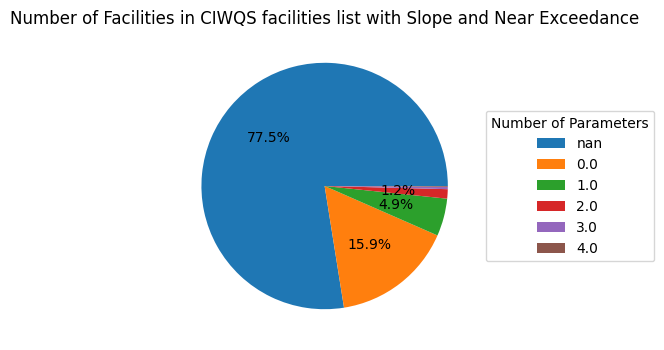

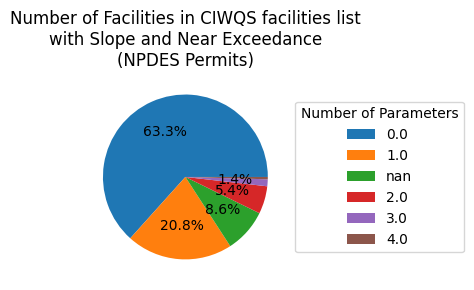

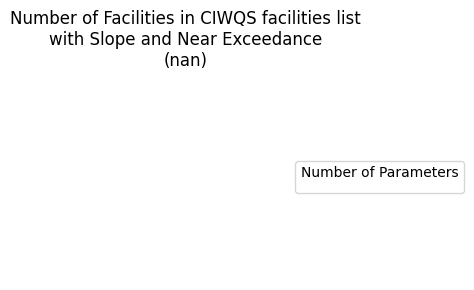

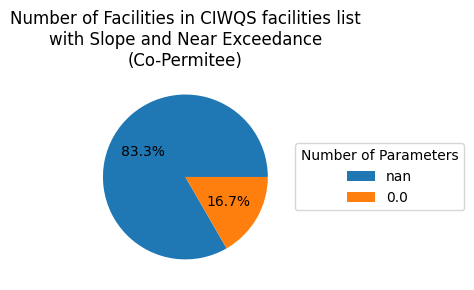

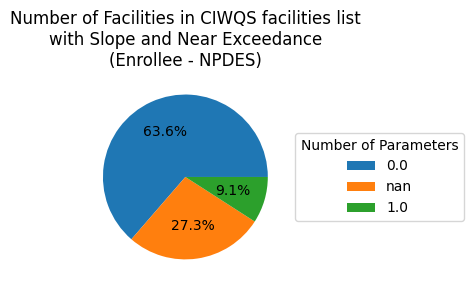

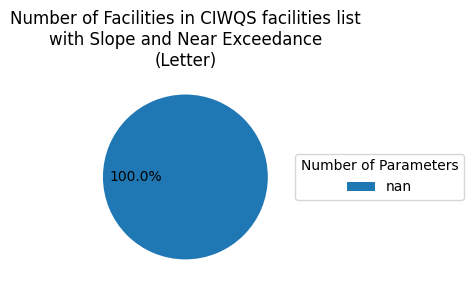

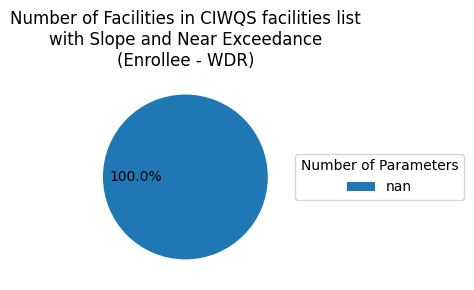

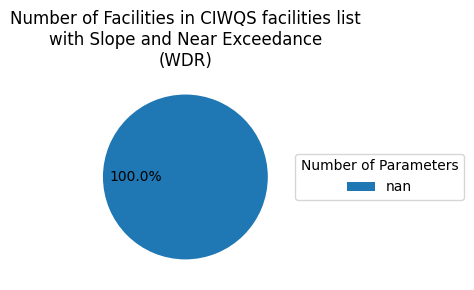

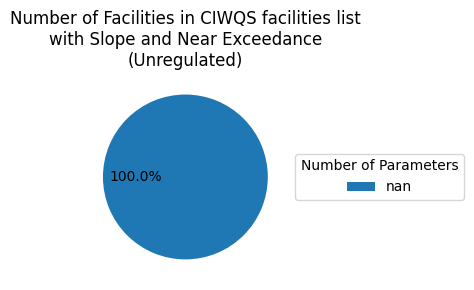

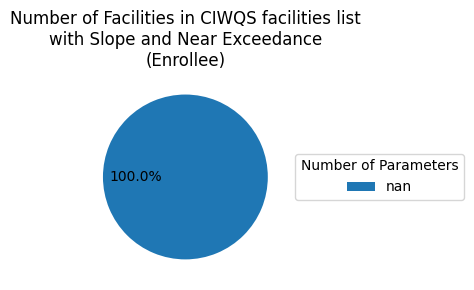

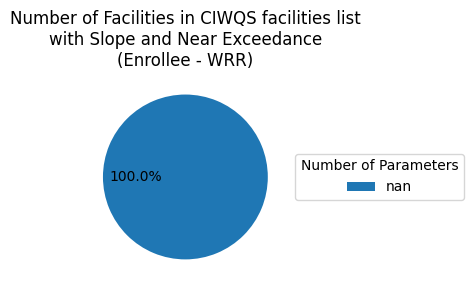

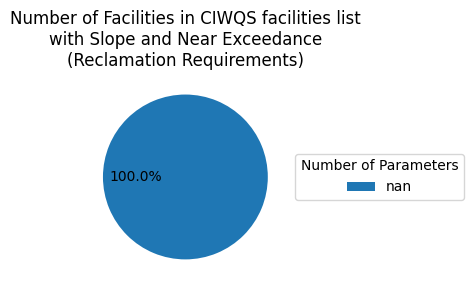

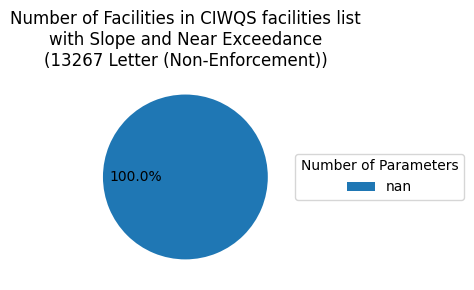

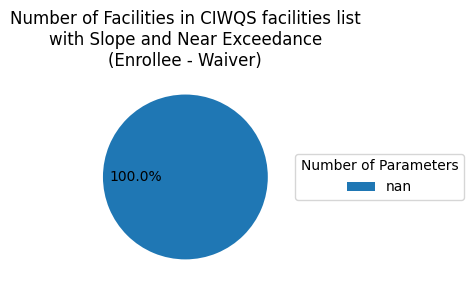

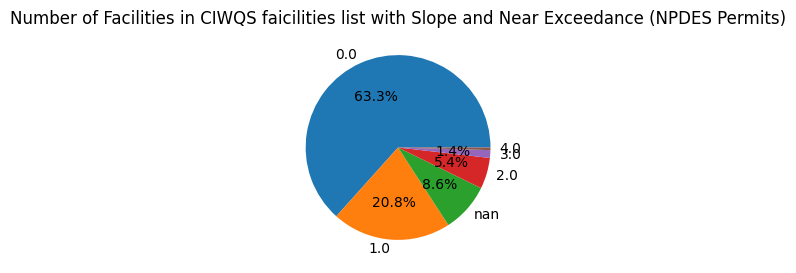

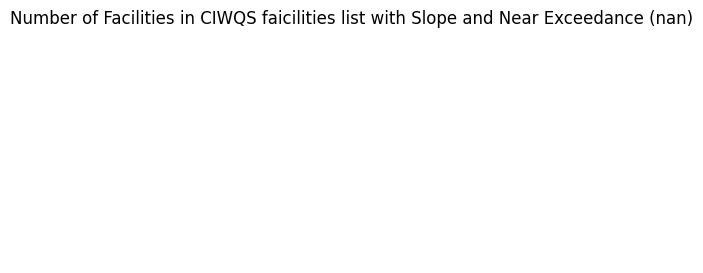

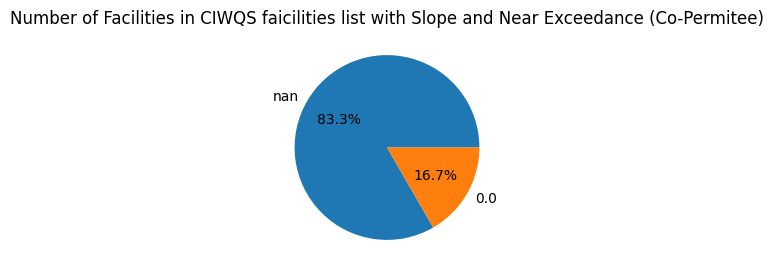

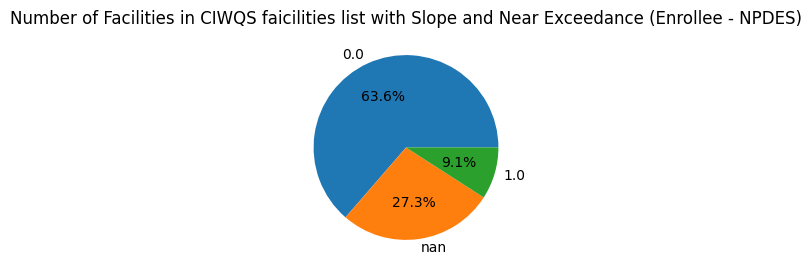

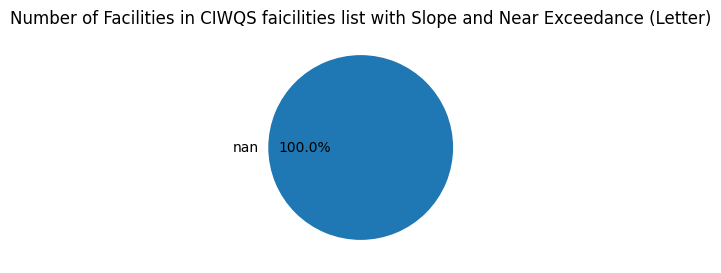

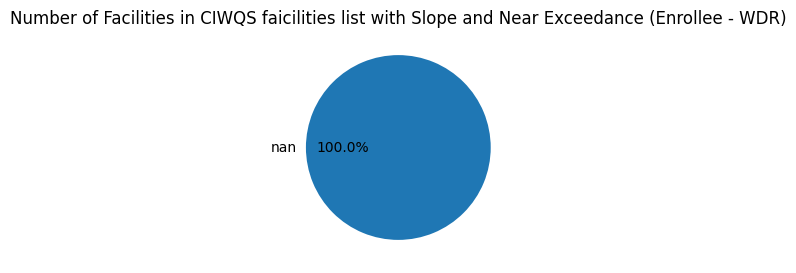

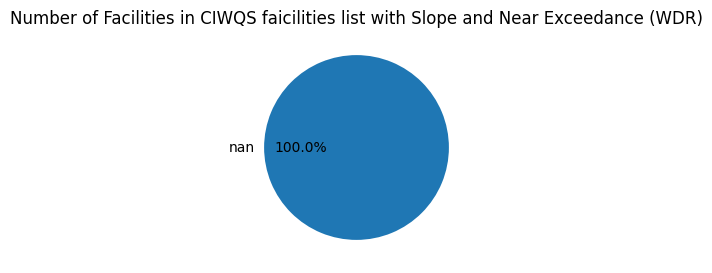

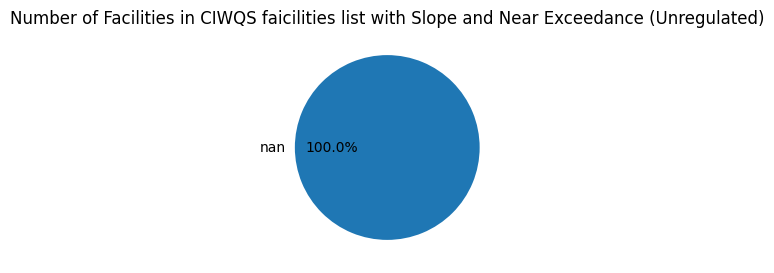

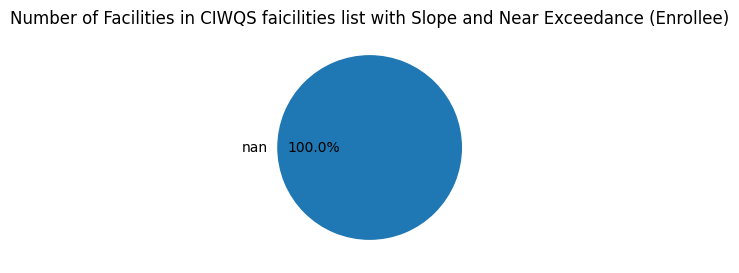

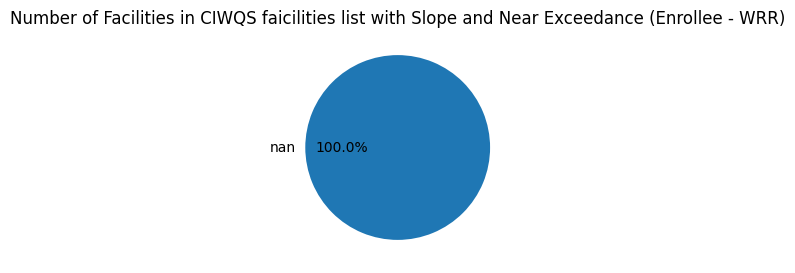

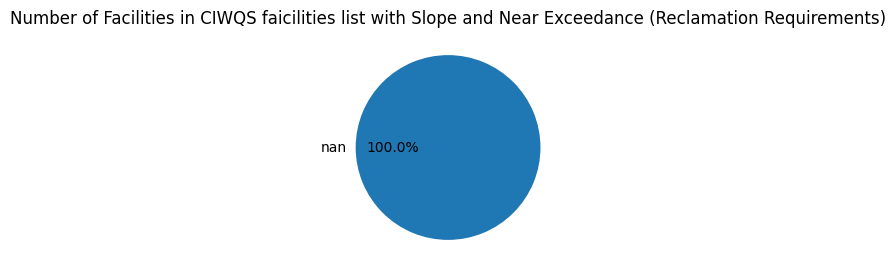

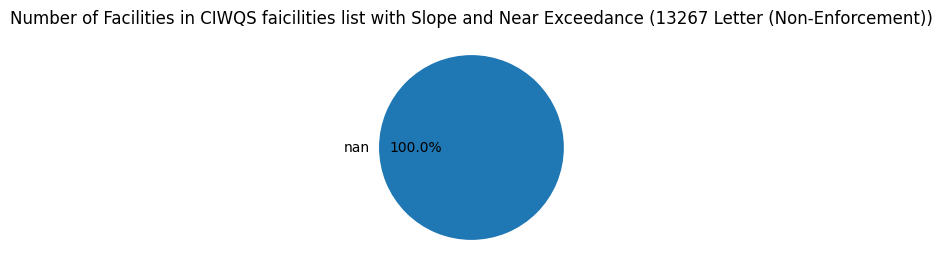

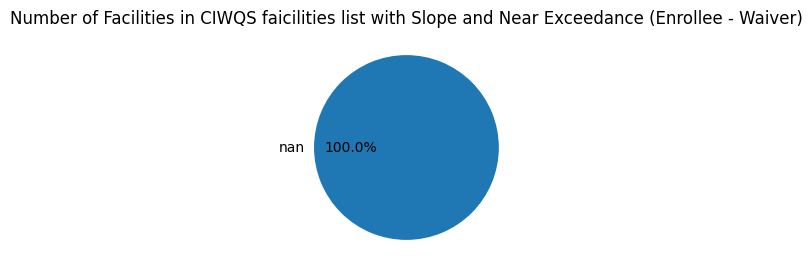

In [ ]:
# import ciwqs_facilities and merge df into ciwqs_facilities based on NPDES_CODE
ciwqs_facilities = pd.read_csv('data/facilities_list/NPDES+WDR Facilities List_20240906.csv')
ciwqs_facilities = ciwqs_facilities.merge(df, left_on='NPDES # CA#', right_on='NPDES_CODE', how='left')
ciwqs_facilities.to_csv('processed_data/ciwqs_facilities.csv', index=False)

def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct > 1 else ''
plt.figure(figsize=(5, 4))
value_counts = ciwqs_facilities['num_parameters'].value_counts(dropna=False)
wedges, texts, autotexts = plt.pie(value_counts.values, autopct=autopct_format)
plt.legend(wedges, value_counts.index, title="Number of Parameters", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Number of Facilities in CIWQS facilities list with Slope and Near Exceedance')
plt.show()

# for each program category
for program_category in ciwqs_facilities['REG MEASURE TYPE'].unique():
    category_facilities = ciwqs_facilities[ciwqs_facilities['REG MEASURE TYPE'] == program_category]
    plt.figure(figsize=(4, 3))
    value_counts = category_facilities['num_parameters'].value_counts(dropna=False)
    wedges, texts, autotexts = plt.pie(value_counts.values, autopct=autopct_format)
    plt.legend(wedges, value_counts.index, title="Number of Parameters", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title(f'Number of Facilities in CIWQS facilities list\nwith Slope and Near Exceedance\n({program_category})')
    plt.tight_layout()
    plt.show()

# for each program category
for program_category in ciwqs_facilities['REG MEASURE TYPE'].unique():
    category_facilities = ciwqs_facilities[ciwqs_facilities['REG MEASURE TYPE'] == program_category]
    plt.figure(figsize=(4, 3))
    value_counts = category_facilities['num_parameters'].value_counts(dropna=False)
    plt.pie(value_counts.values, labels=value_counts.index, autopct=autopct_format)
    plt.title(f'Number of Facilities in CIWQS faicilities list with Slope and Near Exceedance ({program_category})')
    plt.show()

In [ ]:
# print length of esmr data
print(len(esmr_data))

# print the combined length of data_dict[analysis_range]
sum = 0
for year in analysis_range:
    sum += len(data_dict[year])
print(sum)

11246055
483111


In [ ]:
#